In [17]:
import numpy as np

def gini_impurity(y):
    """
    Calculate Gini impurity for a node.
    
    Parameters
    ----------
    y : ndarray, shape (n_samples,)
        Array of class labels for samples in the node
        
    Returns
    -------
    impurity : float
        Gini impurity of the node
    """
    if len(y) == 0:
        return 0
        
    #occurrences of each class
    _, counts = np.unique(y, return_counts=True)
    proportions = counts / len(y)
    
    #Gini impurity
    impurity = 1 - np.sum(proportions ** 2)
    
    return impurity

class ScratchDecesionTreeClassifierDepth1():
    """
    Depth 1 decision tree classifier scratch implementation

    Parameters
    ----------
    verbose : bool
      True to output the learning process
    """

    def __init__(self, verbose=False):
        #hyperparameters as attributes
        self.verbose = verbose
        self.feature_index = None
        self.threshold = None
        self.left_class = None
        self.right_class = None

    def fit(self, X, y):
        """
        Learn the decision tree classifier
        Parameters
        ----------
        X : The following forms of ndarray, shape (n_samples, n_features)
            Features of training data
        y : The following form of ndarray, shape (n_samples,)
            Correct answer value of training data
        """
        n_samples, n_features = X.shape
        
        # Initialize best parameters
        best_gini = float('inf')
        best_feature = 0
        best_threshold = 0
        
        #features and possible thresholds
        for feature in range(n_features):
            #unique values in this feature to try as thresholds
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                # Split data
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                # Skip if split results in empty node
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                
                # Calculate weighted Gini impurity
                gini_left = gini_impurity(y_left)
                gini_right = gini_impurity(y_right)
                
                weighted_gini = (len(y_left) * gini_left + len(y_right) * gini_right) / n_samples
                
                # Update best split if this one is better
                if weighted_gini < best_gini:
                    best_gini = weighted_gini
                    best_feature = feature
                    best_threshold = threshold
                    self.left_class = self._most_common_class(y_left)
                    self.right_class = self._most_common_class(y_right)
        
        # Save the best split parameters
        self.feature_index = best_feature
        self.threshold = best_threshold
        
        if self.verbose:
            print(f"Best split: Feature {best_feature} <= {best_threshold}")
            print(f"Left node class: {self.left_class}, Right node class: {self.right_class}")

    def _most_common_class(self, y):
        """Helper function to find the most common class in a node"""
        unique, counts = np.unique(y, return_counts=True)
        return unique[np.argmax(counts)]

    def predict(self, X):
        """
        Estimate the label using a decision tree classifier
        """
        if self.feature_index is None or self.threshold is None:
            raise Exception("Model not fitted yet")
            
        # Initialize predictions
        predictions = np.empty(X.shape[0], dtype=type(self.left_class))
        
        # Make predictions based on the learned split
        left_mask = X[:, self.feature_index] <= self.threshold
        predictions[left_mask] = self.left_class
        predictions[~left_mask] = self.right_class
        
        return predictions
    

In [18]:
def information_gain(parent_y, left_y, right_y):
    """
    Calculate information gain for a split using Gini impurity.
    
    Parameters
    ----------
    parent_y : ndarray
        Array of class labels in parent node
    left_y : ndarray
        Array of class labels in left child node
    right_y : ndarray
        Array of class labels in right child node
        
    Returns
    -------
    gain : float
        Information gain of the split
    """
    #parent impurity
    parent_impurity = gini_impurity(parent_y)
    
    #child impurities
    left_impurity = gini_impurity(left_y)
    right_impurity = gini_impurity(right_y)
    
    #weights
    n_parent = len(parent_y)
    n_left = len(left_y)
    n_right = len(right_y)
    
    #weighted average of child impurities
    weighted_child_impurity = (n_left * left_impurity + n_right * right_impurity) / n_parent
    
    # Information gain is the reduction in impurity
    gain = parent_impurity - weighted_child_impurity
    
    return gain

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

class ScratchDecesionTreeClassifierDepth1():
    """
    Depth 1 decision tree classifier scratch implementation 
    """
    
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.feature_index = None
        self.threshold = None
        self.left_class = None
        self.right_class = None
    
    def fit(self, X, y):
        """
        Learn the decision tree by finding the best split that maximizes information gain
        """
        n_samples, n_features = X.shape
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        #parent impurity 
        parent_impurity = gini_impurity(y)
        
        for feature in range(n_features):
            #unique values as potential thresholds
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                # Split data
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                # Skip if split would create empty nodes
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                
                # Calculate information gain
                current_gain = information_gain(y, y_left, y_right)
                
                # Update best split if this one is better
                if current_gain > best_gain:
                    best_gain = current_gain
                    best_feature = feature
                    best_threshold = threshold
                    self.left_class = self._most_common_class(y_left)
                    self.right_class = self._most_common_class(y_right)
        
        # Save the best split parameters
        self.feature_index = best_feature
        self.threshold = best_threshold
        
        if self.verbose:
            print(f"Best split found: Feature {best_feature} <= {best_threshold:.4f}")
            print(f"Information gain: {best_gain:.4f}")
            print(f"Left node class: {self.left_class}, Right node class: {self.right_class}")
    
    def _most_common_class(self, y):
        """Helper function to find the most common class in a node"""
        unique, counts = np.unique(y, return_counts=True)
        return unique[np.argmax(counts)]
    
    def predict(self, X):
        """Make predictions using the learned decision tree"""
        if self.feature_index is None or self.threshold is None:
            raise Exception("Model not fitted yet")
            
        predictions = np.empty(X.shape[0], dtype=int)
        left_mask = X[:, self.feature_index] <= self.threshold
        predictions[left_mask] = self.left_class
        predictions[~left_mask] = self.right_class
        return predictions
    
    def visualize_decision_boundary(self, X, y, feature_names=None):
        """
        Visualize the decision boundary for 2D data (for demonstration purposes)
        Note: Only works when we have exactly 2 features
        """
        if X.shape[1] != 2:
            print("Visualization only works for 2D data")
            return
        
        if self.feature_index is None:
            print("Model not trained yet")
            return
        
        # 
        cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
        cmap_bold = ListedColormap(['#FF0000', '#00FF00'])
        
        #decision boundary
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        
        xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                             np.arange(y_min, y_max, 0.02))
        
        # Predict for each point in meshgrid
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        
        plt.figure(figsize=(8, 6))
        plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
        # Plot the training points
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
        
        #decision boundary
        if self.feature_index == 0:
            plt.axvline(x=self.threshold, color='k', linestyle='--')
            plt.text(self.threshold+0.1, y_max-0.1, 
                    f'X{self.feature_index} ≤ {self.threshold:.2f}',
                    fontsize=12)
        else:
            plt.axhline(y=self.threshold, color='k', linestyle='--')
            plt.text(x_max-2, self.threshold+0.1, 
                    f'X{self.feature_index} ≤ {self.threshold:.2f}',
                    fontsize=12)
        
        if feature_names:
            plt.xlabel(feature_names[0])
            plt.ylabel(feature_names[1])
        else:
            plt.xlabel('Feature 0')
            plt.ylabel('Feature 1')
        
        plt.title("Decision boundary of depth-1 decision tree")
        plt.show()

In [20]:
class ScratchDecesionTreeClassifierDepth1():
    """
    Depth 1 decision tree classifier scratch implementation
    """

    def __init__(self, verbose=False):
        # Record hyperparameters as attributes
        self.verbose = verbose
        self.feature_index = None  # Index of feature used for splitting
        self.threshold = None      # Threshold value for splitting
        self.left_class = None     # Class label for left leaf node
        self.right_class = None    # Class label for right leaf node

    def fit(self, X, y):
        """
        Learn the decision tree classifier
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Features of training data
        y : ndarray, shape (n_samples,)
            Correct answer value of training data
        """
        n_samples, n_features = X.shape
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        #parent impurity once
        parent_impurity = gini_impurity(y)
        
        for feature in range(n_features):
            #unique values as potential thresholds
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                # Split data
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                y_left = y[left_mask]
                y_right = y[right_mask]
                
                # Skip if split would create empty nodes
                if len(y_left) == 0 or len(y_right) == 0:
                    continue
                
                # Calculate information gain
                current_gain = information_gain(y, y_left, y_right)
                
                # Update best split if this one is better
                if current_gain > best_gain:
                    best_gain = current_gain
                    best_feature = feature
                    best_threshold = threshold
                    self.left_class = self._most_common_class(y_left)
                    self.right_class = self._most_common_class(y_right)
        
        # Save the best split parameters
        self.feature_index = best_feature
        self.threshold = best_threshold
        
        if self.verbose:
            print(f"Best split found: Feature {best_feature} <= {best_threshold:.4f}")
            print(f"Information gain: {best_gain:.4f}")
            print(f"Left node class: {self.left_class}, Right node class: {self.right_class}")

    def _most_common_class(self, y):
        """Helper function to find the most common class in a node"""
        unique, counts = np.unique(y, return_counts=True)
        return unique[np.argmax(counts)]

    def predict(self, X):
        """
        Estimate the label using the learned decision tree
        
        Parameters
        ----------
        X : ndarray, shape (n_samples, n_features)
            Input data to be classified
            
        Returns
        -------
        predictions : ndarray, shape (n_samples,)
            Predicted class labels
        """
        if self.feature_index is None or self.threshold is None:
            raise ValueError("Model has not been trained yet. Call fit() first.")
        
        # 
        predictions = np.empty(X.shape[0], dtype=type(self.left_class))
        
        # 
        left_mask = X[:, self.feature_index] <= self.threshold
        
        #
        predictions[left_mask] = self.left_class
        predictions[~left_mask] = self.right_class
        
        return predictions

    def decision_function(self, X):
        """
        Return the decision path information (for debugging/analysis)
        Returns which leaf node each sample would reach
        """
        if self.feature_index is None or self.threshold is None:
            raise ValueError("Model has not been trained yet.")
            
        decisions = np.where(X[:, self.feature_index] <= self.threshold, 
                           "Left", "Right")
        return decisions

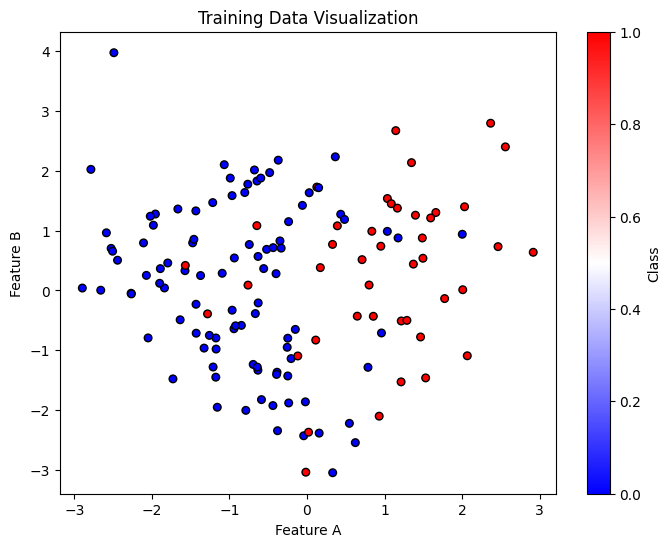

Best split found: Feature 0 <= 0.6238
Information gain: 0.2125
Left node class: 0, Right node class: 1

Scratch Implementation Metrics:
Accuracy:  0.7833
Precision: 0.6154
Recall:    0.5000

scikit-learn Implementation Metrics:
Accuracy:  0.7833
Precision: 0.6154
Recall:    0.5000

Comparison of Splits:
Scratch - Split on Feature A <= 0.6238
scikit-learn - Split on Feature A <= 0.6362


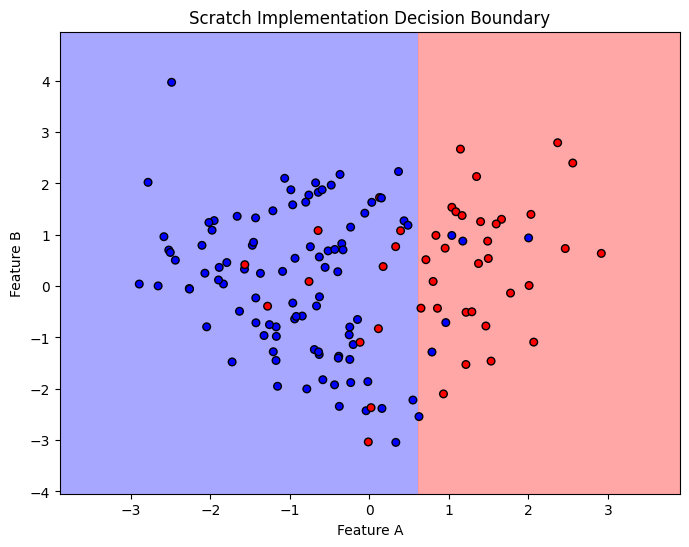

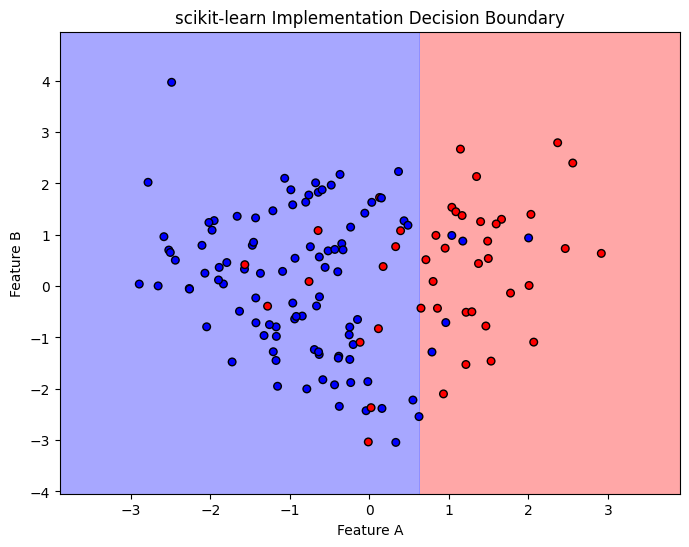

In [21]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier

#
X, y = make_classification(
    n_samples=200,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_classes=2,
    weights=[0.7, 0.3],
    random_state=42,
    flip_y=0.1  
)

#feature names 
feature_names = ["Feature A", "Feature B"]
class_names = ["Class 0", "Class 1"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', edgecolor='k', s=30)
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title("Training Data Visualization")
plt.colorbar(label="Class")
plt.show()

# Initialize and train scratch implementation
scratch_tree = ScratchDecesionTreeClassifierDepth1(verbose=True)
scratch_tree.fit(X_train, y_train)

# Make predictions
scratch_pred = scratch_tree.predict(X_test)

# Calculate metrics
scratch_accuracy = accuracy_score(y_test, scratch_pred)
scratch_precision = precision_score(y_test, scratch_pred)
scratch_recall = recall_score(y_test, scratch_pred)

print("\nScratch Implementation Metrics:")
print(f"Accuracy:  {scratch_accuracy:.4f}")
print(f"Precision: {scratch_precision:.4f}")
print(f"Recall:    {scratch_recall:.4f}")

# Initialize and train scikit-learn's implementation (max_depth=1)
sklearn_tree = DecisionTreeClassifier(max_depth=1, random_state=42)
sklearn_tree.fit(X_train, y_train)

# Make predictions
sklearn_pred = sklearn_tree.predict(X_test)

# Calculate metrics
sklearn_accuracy = accuracy_score(y_test, sklearn_pred)
sklearn_precision = precision_score(y_test, sklearn_pred)
sklearn_recall = recall_score(y_test, sklearn_pred)

print("\nscikit-learn Implementation Metrics:")
print(f"Accuracy:  {sklearn_accuracy:.4f}")
print(f"Precision: {sklearn_precision:.4f}")
print(f"Recall:    {sklearn_recall:.4f}")

# Compare the splits
print("\nComparison of Splits:")
print(f"Scratch - Split on {feature_names[scratch_tree.feature_index]} <= {scratch_tree.threshold:.4f}")
print(f"scikit-learn - Split on {feature_names[sklearn_tree.tree_.feature[0]]} <= {sklearn_tree.tree_.threshold[0]:.4f}")

# decision boundaries
def plot_decision_boundary(clf, X, y, title):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                         np.arange(y_min, y_max, 0.02))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap='bwr')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=30)
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])
    plt.title(title)
    plt.show()

#both decision boundaries
plot_decision_boundary(scratch_tree, X_train, y_train, "Scratch Implementation Decision Boundary")
plot_decision_boundary(sklearn_tree, X_train, y_train, "scikit-learn Implementation Decision Boundary")


class DecisionTreeNode:
    """Node class for our decision tree"""
    
    def __init__(self, max_depth=None, current_depth=0):
        self.max_depth = max_depth
        self.current_depth = current_depth
        self.feature_index = None
        self.threshold = None
        self.left_child = None
        self.right_child = None
        self.class_label = None
    
    def fit(self, X, y):
        """Recursively fit the decision tree"""
        # Base cases
        if len(np.unique(y)) == 1:  # All samples same class
            self.class_label = y[0]
            return
        
        if (self.max_depth is not None and 
            self.current_depth >= self.max_depth):
            self.class_label = self._most_common_class(y)
            return
        
        # Find best split
        best_gain = -1
        best_feature = None
        best_threshold = None
        
        for feature in range(X.shape[1]):
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                gain = information_gain(y, y[left_mask], y[right_mask])
                
                if gain > best_gain:
                    best_gain = gain
                    best_feature = feature
                    best_threshold = threshold
        
        # If no good split found, become leaf node
        if best_gain == -1:
            self.class_label = self._most_common_class(y)
            return
        
        # Store best split
        self.feature_index = best_feature
        self.threshold = best_threshold
        
        # Split data
        left_mask = X[:, best_feature] <= best_threshold
        right_mask = ~left_mask
        
        #child nodes
        self.left_child = DecisionTreeNode(
            max_depth=self.max_depth,
            current_depth=self.current_depth + 1
        )
        self.right_child = DecisionTreeNode(
            max_depth=self.max_depth,
            current_depth=self.current_depth + 1
        )
        
        # 
        self.left_child.fit(X[left_mask], y[left_mask])
        self.right_child.fit(X[right_mask], y[right_mask])
    
    def predict(self, x):
        """Recursively predict class for a single sample"""
        if self.class_label is not None:
            return self.class_label
            
        if x[self.feature_index] <= self.threshold:
            return self.left_child.predict(x)
        else:
            return self.right_child.predict(x)
    
    def _most_common_class(self, y):
        """Helper method to find majority class"""
        unique, counts = np.unique(y, return_counts=True)
        return unique[np.argmax(counts)]


class ScratchDecesionTreeClassifierDepth2:
    """Depth 2 decision tree classifier"""
    
    def __init__(self, verbose=False):
        self.verbose = verbose
        self.root = None
    
    def fit(self, X, y):
        """Fit the decision tree with max_depth=2"""
        self.root = DecisionTreeNode(max_depth=2, current_depth=0)
        self.root.fit(X, y)
        
        if self.verbose:
            print("Decision tree trained with depth 2")
            self.print_tree()
    
    def predict(self, X):
        """Predict class labels for samples"""
        return np.array([self.root.predict(x) for x in X])
    
    def print_tree(self, node=None, indent="", feature_names=None):
        """Print the tree structure (for visualization)"""
        if node is None:
            node = self.root
            if feature_names is None:
                feature_names = [f"Feature {i}" for i in range(len(node.feature_index))] \
                    if hasattr(node, 'feature_index') and node.feature_index is not None else []
        
        if node.class_label is not None:
            print(indent + "Predict class", node.class_label)
        else:
            feature_name = feature_names[node.feature_index] if feature_names else f"Feature {node.feature_index}"
            print(indent + f"{feature_name} <= {node.threshold:.2f}")
            self.print_tree(node.left_child, indent + "  ", feature_names)
            print(indent + f"{feature_name} > {node.threshold:.2f}")
            self.print_tree(node.right_child, indent + "  ", feature_names)

            

            

class ScratchDecesionTreeClassifierDepthInf:
    """
    Decision tree classifier with unlimited depth capability
    
    Parameters
    ----------
    max_depth : int or None, default=None
        The maximum depth of the tree. If None, nodes are expanded until
        all leaves are pure or until all leaves contain less than
        min_samples_split samples.
    min_samples_split : int, default=2
        The minimum number of samples required to split an internal node
    verbose : bool, default=False
        If True, prints training progress
    """
    
    def __init__(self, max_depth=None, min_samples_split=2, verbose=False):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.verbose = verbose
        self.root = None
        self.feature_importances_ = None
    
    def fit(self, X, y, feature_names=None):
        """
        Build a decision tree classifier from the training set (X, y)
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The training input samples
        y : array-like, shape (n_samples,)
            The target values
        feature_names : list of str, optional
            Names of features for better visualization
        """
        self.feature_names = feature_names if feature_names is not None else [
            f"Feature {i}" for i in range(X.shape[1])
        ]
        
        # 
        self.feature_importances_ = np.zeros(X.shape[1])
        
        # 
        self.root = self._build_tree(X, y, current_depth=0)
        
        # 
        self.feature_importances_ /= np.sum(self.feature_importances_)
        
        if self.verbose:
            print("Decision tree training completed")
            self.print_tree()
    
    def _build_tree(self, X, y, current_depth):
        """Recursively build the decision tree"""
        node = {
            'samples': len(y),
            'value': np.bincount(y),
            'impurity': gini_impurity(y),
            'depth': current_depth
        }
        
        # 
        if (len(np.unique(y)) == 1 or  # All samples same class
            (self.max_depth is not None and current_depth >= self.max_depth) or
            len(y) < self.min_samples_split):
            node['class'] = np.argmax(node['value'])
            return node
        
        # 
        best_split = self._find_best_split(X, y)
        if best_split['gain'] <= 0:  # No improvement
            node['class'] = np.argmax(node['value'])
            return node
        
        # Store best split
        node.update(best_split)
        
        # Split data
        left_mask = X[:, best_split['feature']] <= best_split['threshold']
        right_mask = ~left_mask
        
        # 
        node['left'] = self._build_tree(X[left_mask], y[left_mask], current_depth + 1)
        node['right'] = self._build_tree(X[right_mask], y[right_mask], current_depth + 1)
        
        # 
        self.feature_importances_[best_split['feature']] += (
            best_split['gain'] * best_split['samples']
        )
        
        return node
    
    def _find_best_split(self, X, y):
        """Find the best split for a node"""
        best_split = {'gain': -1}
        n_samples, n_features = X.shape
        
        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            
            for threshold in thresholds:
                left_mask = X[:, feature] <= threshold
                right_mask = ~left_mask
                
                if np.sum(left_mask) == 0 or np.sum(right_mask) == 0:
                    continue
                
                gain = information_gain(y, y[left_mask], y[right_mask])
                
                if gain > best_split['gain']:
                    best_split = {
                        'feature': feature,
                        'threshold': threshold,
                        'gain': gain,
                        'samples': n_samples
                    }
        
        return best_split
    
    def predict(self, X):
        """
        Predict class for X
        
        Parameters
        ----------
        X : array-like, shape (n_samples, n_features)
            The input samples
        
        Returns
        -------
        y : ndarray, shape (n_samples,)
            The predicted classes
        """
        return np.array([self._predict_one(x) for x in X])
    
    def _predict_one(self, x, node=None):
        """Predict class for a single sample"""
        if node is None:
            node = self.root
        
        if 'class' in node:
            return node['class']
        
        if x[node['feature']] <= node['threshold']:
            return self._predict_one(x, node['left'])
        else:
            return self._predict_one(x, node['right'])
    
    def print_tree(self, node=None, indent=""):
        """Print the tree structure"""
        if node is None:
            node = self.root
        
        if 'class' in node:
            print(indent + f"Class: {node['class']}", 
                  f"(samples={node['samples']}, value={node['value']}, impurity={node['impurity']:.3f})")
        else:
            feature_name = self.feature_names[node['feature']]
            print(indent + f"{feature_name} <= {node['threshold']:.3f}",
                  f"(samples={node['samples']}, value={node['value']}, impurity={node['impurity']:.3f}, gain={node['gain']:.3f})")
            self.print_tree(node['left'], indent + "  ")
            print(indent + f"{feature_name} > {node['threshold']:.3f}")
            self.print_tree(node['right'], indent + "  ")
    
    def get_depth(self, node=None):
        """Get the maximum depth of the tree"""
        if node is None:
            node = self.root
        
        if 'class' in node:
            return node['depth']
        
        return max(
            self.get_depth(node['left']),
            self.get_depth(node['right'])
        )